# Getting started

This notebook shows how to get started with Quantus on tensorflow, using a very simple example.

In [1]:
import tensorflow as tf  # noqa
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import quantus

## 1. Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [2]:
# Load datasets
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2022-08-11 12:24:38.301521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


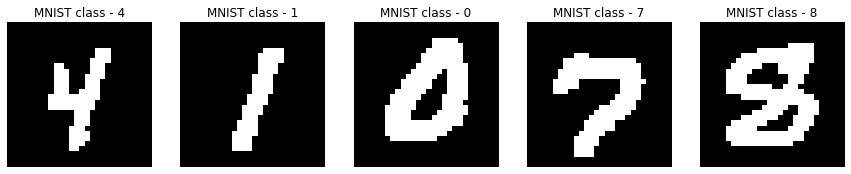

In [3]:
# Plot some inputs!
i = 0
nr_images = 5
fig, axes = plt.subplots(
    nrows=1, ncols=nr_images, figsize=(nr_images * 3, int(nr_images * 2 / 3))
)
for x_batch, y_batch in ds_train.take(nr_images):
    axes[i].imshow(
        (np.reshape(x_batch.numpy(), (28, 28)) * 255).astype(np.uint8),
        vmin=0.0,
        vmax=1.0,
        cmap="gray",
    )
    axes[i].title.set_text(f"MNIST class - {y_batch}")
    axes[i].axis("off")
    i += 1

plt.show()

In [4]:
ds_train = ds_train.batch(128)
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32) / 255, y))
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(128)
ds_test = ds_test.map(lambda x, y: (tf.cast(x, tf.float32) / 255, y))
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


x_batch, y_batch = next(ds_test.take(1).as_numpy_iterator())
x_batch.shape

2022-08-11 12:24:38.586170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-11 12:24:38.586222: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

### 1.2 Train a model

In [5]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation='softmax'),
    ]
)
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"],
    jit_compile=True,
)

model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
469/469 [==============================] - 48s 95ms/step - loss: 0.2573 - accuracy: 0.9241 - val_loss: 0.0655 - val_accuracy: 0.9795
Epoch 2/5
469/469 [==============================] - 40s 86ms/step - loss: 0.0658 - accuracy: 0.9794 - val_loss: 0.0541 - val_accuracy: 0.9817
Epoch 3/5
469/469 [==============================] - 40s 85ms/step - loss: 0.0442 - accuracy: 0.9863 - val_loss: 0.0425 - val_accuracy: 0.9847
Epoch 4/5
469/469 [==============================] - 46s 98ms/step - loss: 0.0348 - accuracy: 0.9893 - val_loss: 0.0354 - val_accuracy: 0.9888
Epoch 5/5
469/469 [==============================] - 46s 97ms/step - loss: 0.0278 - accuracy: 0.9912 - val_loss: 0.0382 - val_accuracy: 0.9884


### 1.3 Generate explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [6]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch_intgrad = quantus.explain(model, x_batch, y_batch, method="IntegratedGradients")

/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/explanation_func.py:52: UserWarning: Using quantus 'explain' function as an explainer without specifying 'attributor'in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(


Visualise attributions given model and pairs of input-output.

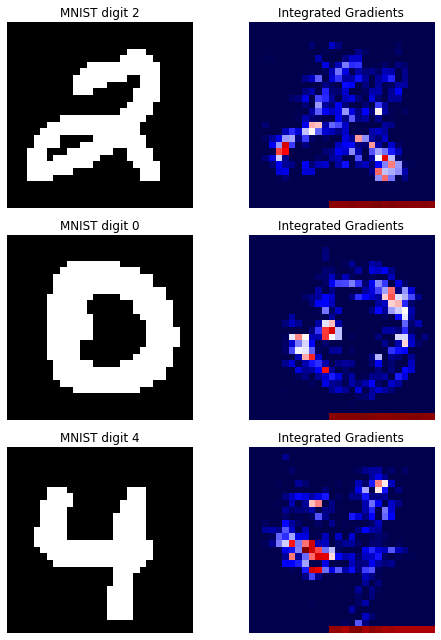

In [7]:
# Plot explanations!
nr_images = 3
fig, axes = plt.subplots(
    nrows=nr_images, ncols=2, figsize=(nr_images * 2.5, int(nr_images * 3))
)
for i in range(nr_images):
    axes[i, 0].imshow(
        (np.reshape(x_batch[i], (28, 28)) * 255).astype(np.uint8),
        vmin=0.0,
        vmax=1.0,
        cmap="gray",
    )
    axes[i, 0].title.set_text(f"MNIST digit {y_batch[i].item()}")
    axes[i, 0].axis("off")
    a = axes[i, 1].imshow(a_batch_intgrad[i], cmap="seismic")
    axes[i, 1].title.set_text(f"Integrated Gradients")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()

## 2. Quantative evaluation using Quantus

We can evaluate our explanations on a variety of quantuative criteria but as a motivating example we test the Max-Sensitivity, Selectivuty, Relativer Input Stability

In [15]:
# Define params for evaluation.
params_eval_maxs = {
    "nr_samples": 10,
    "perturb_radius": 0.1,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "perturb_func": quantus.uniform_noise,
    "similarity_func": quantus.difference,
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "display_progressbar": True,
}

ris_eval_params = {
    "explain_func": quantus.explain,
    "method": "IntegratedGradients",
    "return_aggregate": True,
    "disable_warnings": True,
    "display_progressbar": True,
}




metrics = {
    "max-sensitivity": quantus.MaxSensitivity(**params_eval_maxs),
    "relative-input-stability": quantus.RelativeInputStability(**ris_eval_params),
}

xai_methods = {"IntegratedGradients": a_batch_intgrad}

tf_model = quantus.TensorFlowModel(model, False)

results = quantus.evaluate(
    evaluation_metrics=metrics,
    explanation_methods=xai_methods,
    model=tf_model,
    x_batch=x_batch,
    y_batch=y_batch,
    agg_func=np.mean,
    metrics=metrics,
    xai_methods=xai_methods,
    **{"explain_func": quantus.explain, "img_size": 28, "normalise": True, "abs": True}
)

df = pd.DataFrame(results)
df


argument 'img_size' is deprecated and will be removed in future versions.



Evaluation of MaxSensitivity metric.:   0%|          | 0/128 [00:00<?, ?it/s]/Users/artemsereda/Documents/PycharmProjects/Quantus/quantus/helpers/explanation_func.py:52: UserWarning: Using quantus 'explain' function as an explainer without specifying 'attributor'in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(
Evaluation of MaxSensitivity metric.: 100%|██████████| 128/128 [00:07<00:00, 16.84it/s]


,IntegratedGradients
max-sensitivity,0.420119
relative-input-stability,15928.661133


### Calculate Selectivity (Ancona et al., 2019)

In [17]:

params_eval_slct = {
    "disable_warnings": True,
    "normalise": True,
    "abs": True,
    "patch_size": 4,
    "nr_channels": 1,
    "display_progressbar": True,
}

scores_intgrad_slct = quantus.Selectivity(**params_eval_slct)(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch_intgrad,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "img_size": 28, "normalise": True, "abs": True})

scores_intgrad_slct


argument 'img_size' is deprecated and will be removed in future versions.



Evaluation of Selectivity metric.: 100%|██████████| 128/128 [02:05<00:00,  1.02it/s]


{0: [0.9999862909317017,
  0.9999631643295288,
  0.9999662637710571,
  0.9999517202377319,
  0.9999409914016724,
  0.999947190284729,
  0.9999425411224365,
  0.999890923500061,
  0.9994314312934875,
  0.9991970658302307,
  0.9992603659629822,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992414712905884,
  0.9992493987083435,
  0.998771607875824,
  0.9978273510932922,
  0.9932641983032227,
  0.9910735487937927,
  0.9713426232337952,
  0.9713426232337952,
  0.9761448502540588,
  0.9435617327690125,
  0.9476546049118042,
  0.8709263205528259,
  0.892238974571228,
  0.9070211052894592,
  0.90861576795578,
  0.8973247408866882,
  0.9186401963233948,
  0.876491129398346,
  0.6576787233